In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import fastai
import numpy as np
from numpy import zeros, ones, flipud, log
from numpy.linalg import inv, eig, cholesky as chol
from statsmodels.regression.linear_model import OLS
import pickle as pkl
from tqdm import tqdm

In [2]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')
plt.style.use('seaborn-dark-palette')
plt.rcParams["mathtext.fontset"] = "cm"

In [3]:
oex_tickers = ["AAPL", "ABBV", "ABT", "ACN","ADBE","AIG", "ALL", "AMGN", "AMT", "AMZN", "AXP", "BA", "BAC","BIIB","BK","BKNG","BLK","BMY","C","CAT","CHTR","CL","CMCSA","COF","COP","COST","CRM","CSCO","CVS","CVX","DD","DHR","DIS","DUK","EMR","EXC","F","FB","FDX","GD","GE","GILD","GM","GOOG","GOOGL","GS","HD","HON","IBM","INTC","JNJ","JPM","KHC","KMI","KO","LLY","LMT","LOW","MA","MCD","MDLZ","MDT","MET","MMM","MO","MRK","MS","MSFT","NEE","NFLX","NKE","NVDA","ORCL","OXY","PEP","PFE","PG","PM","PYPL","QCOM","RTX","SBUX","SLB","SO","SPG","T","TGT","TMO","UNH","UNP","UPS","USB","V","VZ","WBA","WFC","WMT","XOM"]

In [4]:
training_data = pd.read_pickle("data_dump/training_oex_5y_data.pkl")
training_data = training_data.drop(["OW", "BRK.B", "XN"])

In [5]:
import time
from core import Position, PositionType
from utils.general import change_above_threshold


class simulation:
    def __init__(self, time_series, model, thresholder, safepredict):
        self.time_series = time_series
        self.model = model
        self.thresholder = thresholder
        self.safepredict = safepredict

# For 30 Jan
For eight varying stocks two techs,

two industrials, two financials, two retails. 

First 6 months, each machine learning model. 

Second 6 months, linear regression and random forest meta model. 

Third 6 months thresholding without changing anything. 

Fourth 6 months to train the initial acceptance probability 

Remaining time up to but not including the last 18 months 

compare the resulting model with buy and hold. 


In [31]:
from utils.general import training_data_for_t
from sklearn.linear_model import SGDRegressor
import time
from core import Position, PositionType
from utils.general import change_above_threshold

def liquidate_position(position, at_price, current_balance, verbose):
    updated_balance = current_balance

    # sell from previous buy
    if position.type == PositionType.BUY:
        updated_balance += (at_price * position.amount)
        log = 'Actual price is {} | Selling'.format(at_price)
#         print(log) if verbose else None

    # buy back from previous short
    if position.type == PositionType.SHORT:
        updated_balance -= (at_price * position.amount)
        log = 'Actual price is {} | Buying back'.format(at_price)
#         print(log) if verbose else None

    return updated_balance

def simulate_trades(predictions, ground_truth, thresholds=None, slowed=False, verbose=False, print_result = False):
#     print(len(thresholds), len(ground_truth))
    assert len(thresholds) == len(ground_truth)
    ground_truth = ground_truth[1:]

    # tracking historic data
    balance_over_time = []

    balance = 0
    position = None
    n_trades = 0
    
    t = 0
    while t < len(ground_truth):
        curr_price = ground_truth[t]
        next_prediction = predictions[t]

        if position is not None:
            balance = liquidate_position(position, at_price=curr_price, current_balance=balance, verbose=verbose)

            # clear position and update data
            position = None

            n_trades += 1
            balance_over_time.append(balance)

            print('\nBalance: {}\n'.format(balance)) if verbose else None
#         if next_prediction == -1:
#             continue
        if next_prediction > 0:
            # check threshold
            if abs(next_prediction/curr_price) >= thresholds[t]:
                # buy and sell tomorrow
                position = Position(position_type=PositionType.BUY, amount=1)
                balance -= (curr_price * position.amount)

                log = 'Current price is {}, Predicting price at t+1 to be {} | Buying one share'.format(curr_price,
                                                                                                        next_prediction)
                print(log) if verbose else None
            else:
                balance_over_time.append(balance)

                log = 'Change not above threshold, not taking action'
                print(log) if verbose else None

        elif next_prediction < 0:
            # check threshold
            if abs(next_prediction/curr_price) >= thresholds[t]:
                # short and buy back tomorrow
                position = Position(position_type=PositionType.SHORT, amount=1)
                balance += (curr_price * position.amount)

                log = 'Current price is {}, Predicting price at t+1 to be {} | Shorting one share'.format(curr_price,
                                                                                                          next_prediction)
                print(log) if verbose else None
            else:
                balance_over_time.append(balance)

                log = 'Change not above threshold, not taking action'
                print(log) if verbose else None
        
            
        t = t + 1
        if slowed:
            time.sleep(2)

    # a position can be left over, so liquidate to get correct balance amount
    if position:
        balance = liquidate_position(position, at_price=ground_truth[-1], current_balance=balance, verbose=verbose)
        n_trades += 1
        balance_over_time.append(balance)

    log = 'Simulation done. Executed {} trades, Final Balance: {}'.format(n_trades, balance)
    print(log) if print_result else None

    return balance_over_time

In [32]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor


def fit_base_ensemble(models, X_train, X_val, y_train, y_val):
    meta_X = list()
    for name, model in models:
        model.fit(X_train, y_train)
        yhat = model.predict(X_val)
        yhat = yhat.reshape(len(yhat), 1)
        meta_X.append(yhat)
    meta_X = np.hstack(meta_X)
#     blender.fit(meta_X, y_val)
    return meta_X

def predict_base_ensemble(models, X_val):
    meta_X = list()
    for name, model in models:
        yhat = model.predict(X_val)
        yhat = yhat.reshape(len(yhat), 1)
        meta_X.append(yhat)
    meta_X = np.hstack(meta_X)
    return meta_X

def fit_meta_ensemble(meta_X, y_val, meta_model):
    meta_model.fit(meta_X, y_val)
    return meta_model

def fit_full_ensemble(models, X_train, X_val, y_train, y_val, meta_model):
    meta = fit_base_ensemble(models, X_train, X_val, y_train, y_val)
    return fit_meta_ensemble(meta, y_val, meta_model)


def predict_ensemble(models, blender, X_test):
    meta_X = list()
    for name, model in models:
        yhat = model.predict(X_test)
        yhat = yhat.reshape(len(yhat), 1)
        meta_X.append(yhat)
    meta_X = np.hstack(meta_X)
    return blender.predict(meta_X)

In [33]:
from methods.svm import SVM
from preparers import ticker_default
from core.functions import forecast
from core.simulation import simulate_trades_continuous
from utils.viz import plot_time_series, plot_balance, plot_balance_vs_price
from utils.general import differentiate, inv_differentiate

Training base models
Training meta models









  0%|          | 0/752 [00:00<?, ?it/s]






  1%|          | 4/752 [00:00<00:19, 39.24it/s]

Predicting with no thresholding









  1%|          | 8/752 [00:00<00:19, 39.14it/s]






  2%|▏         | 12/752 [00:00<00:18, 39.25it/s]






  2%|▏         | 16/752 [00:00<00:19, 38.66it/s]






  3%|▎         | 20/752 [00:00<00:19, 38.24it/s]






  3%|▎         | 24/752 [00:00<00:19, 36.51it/s]






  4%|▎         | 28/752 [00:00<00:21, 34.01it/s]






  4%|▍         | 32/752 [00:00<00:21, 33.93it/s]






  5%|▍         | 36/752 [00:01<00:20, 34.64it/s]






  5%|▌         | 41/752 [00:01<00:19, 36.43it/s]






  6%|▌         | 46/752 [00:01<00:18, 38.11it/s]






  7%|▋         | 50/752 [00:01<00:18, 38.32it/s]






  7%|▋         | 54/752 [00:01<00:18, 38.50it/s]






  8%|▊         | 58/752 [00:01<00:18, 38.53it/s]






  8%|▊         | 62/752 [00:01<00:17, 38.60it/s]






  9%|▉         | 66/752 [00:01<00:17, 39.00it/s]






  9%|▉         | 70/752 [00:01<00:17, 38.77it/s]






 10%|▉         | 74/752 [00:01<00:17, 38.92it/s]






 10%|█         | 78/752 [00:02<00:17, 38.36it/s]






 11%

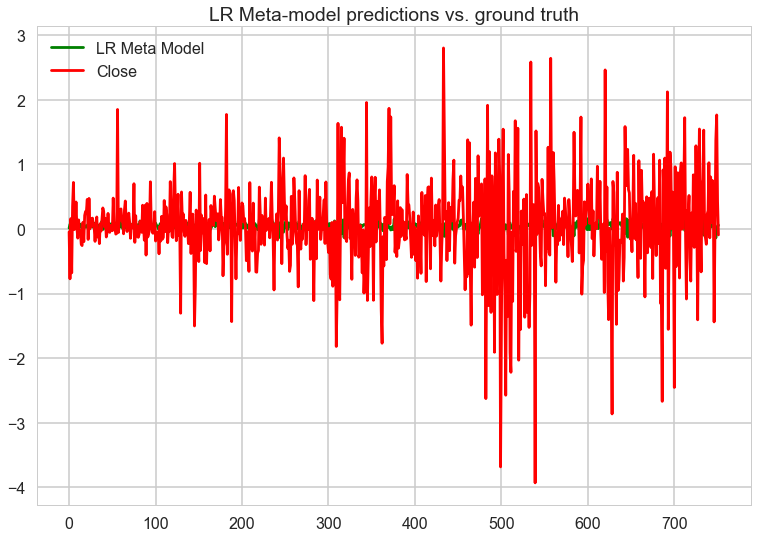

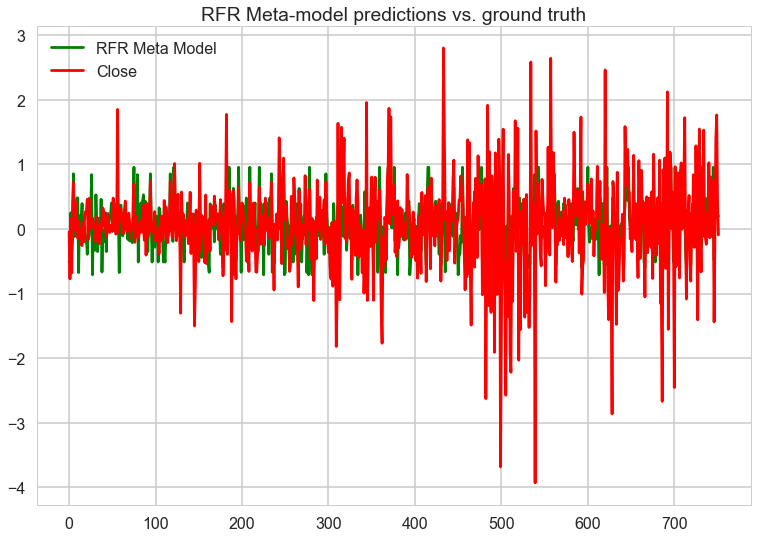

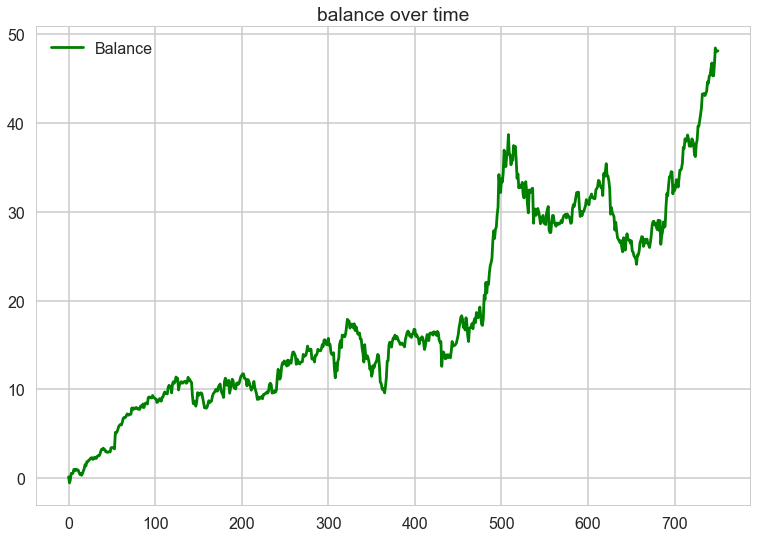

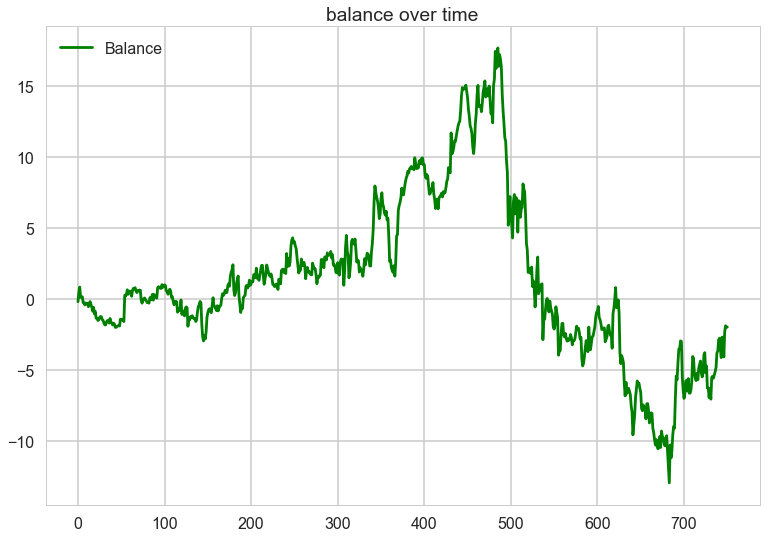

In [34]:
bmodels = list()
bmodels.append(('lr', LinearRegression()))
bmodels.append(('knn', KNeighborsRegressor()))
bmodels.append(('cart', DecisionTreeRegressor()))
bmodels.append(('svm', SVR()))
bmodels.append(("rf", RandomForestRegressor()))

first_df = training_data.loc["AAPL"].dropna()
y_past = first_df[0:first_df.shape[0]-1]
y_current = first_df[1:first_df.shape[0]]
y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

num_days_year = 253

ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
assert len(x_features) == len(y_features)
predictions_lr = []
predictions_rfr = []
thresholds = []
base_training_X = x_features[:start_t].reset_index(drop=True)
base_training_y = y_features[:start_t].reset_index(drop=True)
base_val_X = x_features[start_t:start_t*2].reset_index(drop=True)
base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)

print("Training base models")
meta_X = fit_base_ensemble(bmodels, base_training_X, base_val_X, base_training_y, base_val_y)
print("Training meta models")
meta_lr = fit_meta_ensemble(meta_X, base_val_y, LinearRegression(fit_intercept=False))
meta_rfr = fit_meta_ensemble(meta_X, base_val_y, RandomForestRegressor(bootstrap=False))
print("Predicting with no thresholding")
for t_i in tqdm(range(len(y_features) - start_t*2)):
    current_t = t_i + start_t*2
    threshold = 0
    thresholds.append(threshold)
    predictions_lr.append(predict_ensemble(bmodels, meta_lr, np.asarray([x_features.iloc[current_t]])))
    predictions_rfr.append(predict_ensemble(bmodels, meta_rfr, np.asarray([x_features.iloc[current_t]])))
balances_lr = simulate_trades(predictions_lr, ground_truth[start_t*2:], thresholds)
balances_rfr = simulate_trades(predictions_rfr, ground_truth[start_t*2:], thresholds)
plot_time_series(ts_1=predictions_lr, ts_label_1='LR Meta Model', ts_2=x_features[start_t*2:], ts_label_2='Close', title='LR Meta-model predictions vs. ground truth')
plot_time_series(ts_1=predictions_rfr, ts_label_1='RFR Meta Model', ts_2=x_features[start_t*2:], ts_label_2='Close', title='RFR Meta-model predictions vs. ground truth')
plot_balance(data=balances_lr)
plot_balance(data=balances_rfr)

# Sliding training for Meta models

Training base models
Training meta models









  0%|          | 0/752 [00:00<?, ?it/s]






  0%|          | 1/752 [00:00<02:03,  6.08it/s]

Predicting with no thresholding









  0%|          | 2/752 [00:00<02:02,  6.12it/s]






  0%|          | 3/752 [00:00<02:04,  6.03it/s]






  1%|          | 4/752 [00:00<02:03,  6.07it/s]






  1%|          | 5/752 [00:00<02:01,  6.14it/s]






  1%|          | 6/752 [00:00<01:57,  6.34it/s]






  1%|          | 7/752 [00:01<01:53,  6.54it/s]






  1%|          | 8/752 [00:01<01:50,  6.75it/s]






  1%|          | 9/752 [00:01<01:51,  6.66it/s]






  1%|▏         | 10/752 [00:01<01:53,  6.52it/s]






  1%|▏         | 11/752 [00:01<01:51,  6.62it/s]






  2%|▏         | 12/752 [00:01<01:51,  6.67it/s]






  2%|▏         | 13/752 [00:01<01:49,  6.75it/s]






  2%|▏         | 14/752 [00:02<01:49,  6.75it/s]






  2%|▏         | 15/752 [00:02<01:48,  6.82it/s]






  2%|▏         | 16/752 [00:02<01:55,  6.37it/s]






  2%|▏         | 17/752 [00:02<02:02,  5.98it/s]






  2%|▏         | 18/752 [00:02<02:11,  5.60it/s]






  3%|▎         | 19/752 [00:03<02:12,  5.55it/s]






  3%|▎     

 29%|██▊       | 215/752 [00:33<01:16,  7.01it/s]






 29%|██▊       | 216/752 [00:33<01:20,  6.65it/s]






 29%|██▉       | 217/752 [00:33<01:26,  6.22it/s]






 29%|██▉       | 218/752 [00:33<01:21,  6.54it/s]






 29%|██▉       | 219/752 [00:33<01:24,  6.34it/s]






 29%|██▉       | 220/752 [00:34<01:29,  5.97it/s]






 29%|██▉       | 221/752 [00:34<01:28,  5.97it/s]






 30%|██▉       | 222/752 [00:34<01:25,  6.23it/s]






 30%|██▉       | 223/752 [00:34<01:24,  6.24it/s]






 30%|██▉       | 224/752 [00:34<01:25,  6.19it/s]






 30%|██▉       | 225/752 [00:34<01:26,  6.10it/s]






 30%|███       | 226/752 [00:34<01:25,  6.17it/s]






 30%|███       | 227/752 [00:35<01:23,  6.31it/s]






 30%|███       | 228/752 [00:35<01:20,  6.55it/s]






 30%|███       | 229/752 [00:35<01:20,  6.49it/s]






 31%|███       | 230/752 [00:35<01:19,  6.53it/s]






 31%|███       | 231/752 [00:35<01:20,  6.47it/s]






 31%|███       | 232/752 [00:35<01:18,  6.60it/s

 57%|█████▋    | 427/752 [01:04<00:45,  7.11it/s]






 57%|█████▋    | 428/752 [01:04<00:45,  7.16it/s]






 57%|█████▋    | 429/752 [01:04<00:44,  7.29it/s]






 57%|█████▋    | 430/752 [01:04<00:44,  7.24it/s]






 57%|█████▋    | 431/752 [01:04<00:43,  7.31it/s]






 57%|█████▋    | 432/752 [01:04<00:43,  7.38it/s]






 58%|█████▊    | 433/752 [01:04<00:43,  7.36it/s]






 58%|█████▊    | 434/752 [01:05<00:43,  7.35it/s]






 58%|█████▊    | 435/752 [01:05<00:43,  7.28it/s]






 58%|█████▊    | 436/752 [01:05<00:43,  7.19it/s]






 58%|█████▊    | 437/752 [01:05<00:43,  7.19it/s]






 58%|█████▊    | 438/752 [01:05<00:44,  7.09it/s]






 58%|█████▊    | 439/752 [01:05<00:45,  6.93it/s]






 59%|█████▊    | 440/752 [01:05<00:46,  6.77it/s]






 59%|█████▊    | 441/752 [01:06<00:46,  6.63it/s]






 59%|█████▉    | 442/752 [01:06<00:47,  6.53it/s]






 59%|█████▉    | 443/752 [01:06<00:48,  6.39it/s]






 59%|█████▉    | 444/752 [01:06<00:49,  6.24it/s

 85%|████████▍ | 639/752 [01:36<00:15,  7.11it/s]






 85%|████████▌ | 640/752 [01:36<00:15,  7.08it/s]






 85%|████████▌ | 641/752 [01:36<00:15,  7.16it/s]






 85%|████████▌ | 642/752 [01:36<00:15,  7.08it/s]






 86%|████████▌ | 643/752 [01:36<00:15,  7.10it/s]






 86%|████████▌ | 644/752 [01:36<00:15,  7.06it/s]






 86%|████████▌ | 645/752 [01:36<00:15,  7.07it/s]






 86%|████████▌ | 646/752 [01:37<00:14,  7.14it/s]






 86%|████████▌ | 647/752 [01:37<00:14,  7.14it/s]






 86%|████████▌ | 648/752 [01:37<00:14,  7.18it/s]






 86%|████████▋ | 649/752 [01:37<00:14,  7.13it/s]






 86%|████████▋ | 650/752 [01:37<00:14,  7.12it/s]






 87%|████████▋ | 651/752 [01:37<00:14,  7.11it/s]






 87%|████████▋ | 652/752 [01:37<00:14,  7.10it/s]






 87%|████████▋ | 653/752 [01:38<00:13,  7.15it/s]






 87%|████████▋ | 654/752 [01:38<00:13,  7.10it/s]






 87%|████████▋ | 655/752 [01:38<00:13,  7.03it/s]






 87%|████████▋ | 656/752 [01:38<00:13,  6.95it/s

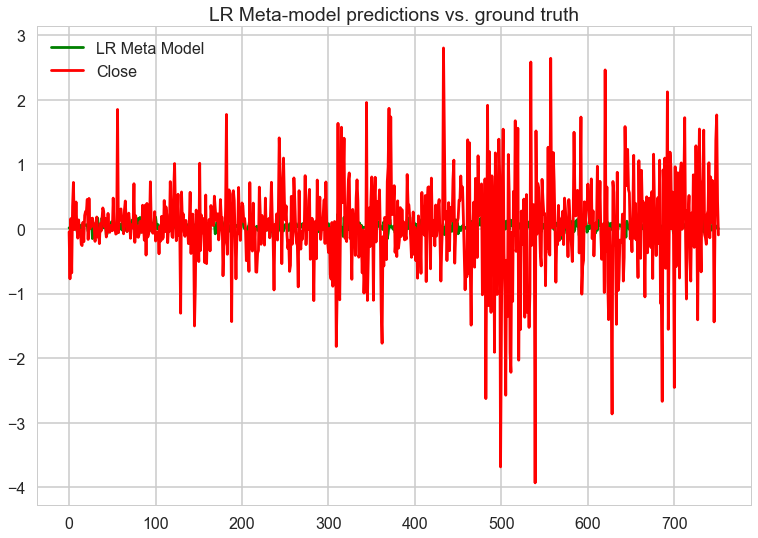

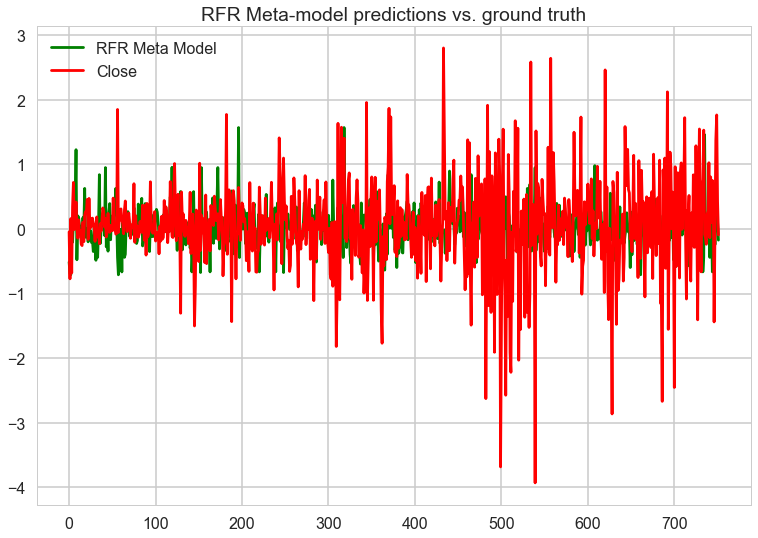

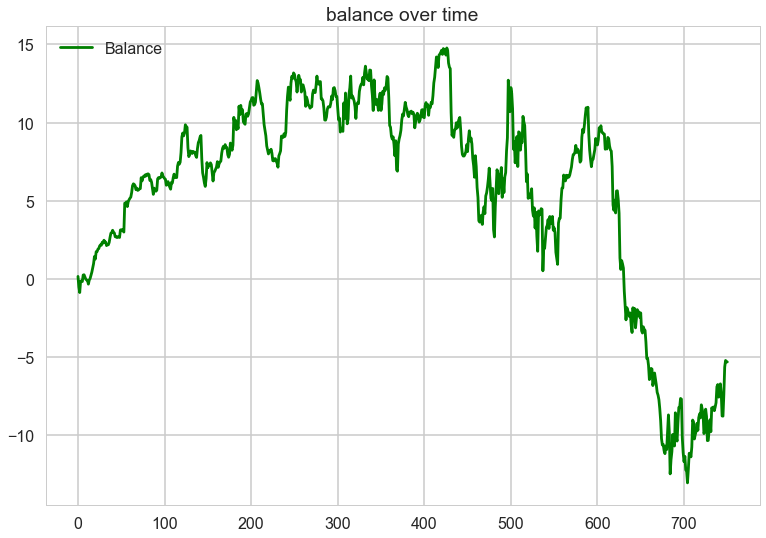

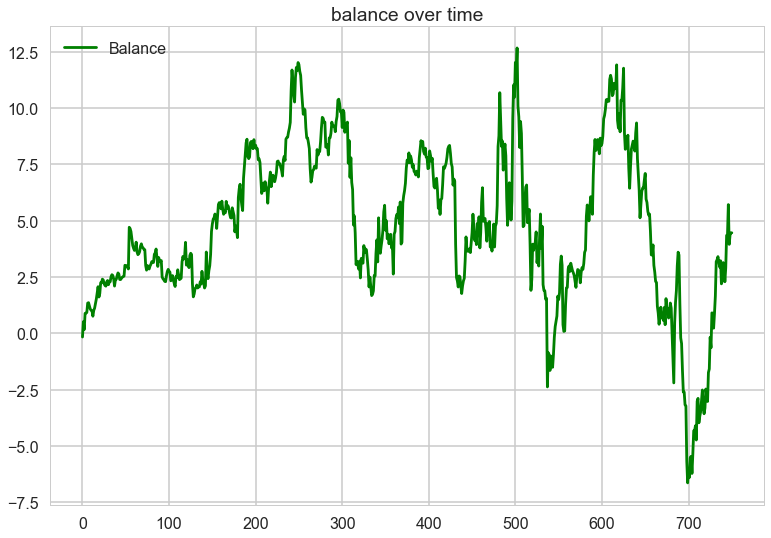

In [35]:
bmodels = list()
bmodels.append(('lr', LinearRegression()))
bmodels.append(('knn', KNeighborsRegressor()))
bmodels.append(('cart', DecisionTreeRegressor()))
bmodels.append(('svm', SVR()))
bmodels.append(("rf", RandomForestRegressor()))

first_df = training_data.loc["AAPL"].dropna()
y_past = first_df[0:first_df.shape[0]-1]
y_current = first_df[1:first_df.shape[0]]
y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

num_days_year = 253
look_back_sliding = num_days_year

ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
assert len(x_features) == len(y_features)
predictions_lr = []
predictions_rfr = []
thresholds = []
base_training_X = x_features[:start_t].reset_index(drop=True)
base_training_y = y_features[:start_t].reset_index(drop=True)
base_val_X = x_features[start_t:start_t*2].reset_index(drop=True)
base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)
# print(base_training_X, base_training_y,base_val_X, base_val_y)

print("Training base models")
meta_X_init = fit_base_ensemble(bmodels, base_training_X, base_val_X, base_training_y, base_val_y)
print("Training meta models")
meta_lr = fit_meta_ensemble(meta_X_init, base_val_y, LinearRegression(fit_intercept=False))
meta_rfr = fit_meta_ensemble(meta_X_init, base_val_y, RandomForestRegressor(bootstrap=False))
print("Predicting with no thresholding")
for t_i in tqdm(range(len(y_features) - start_t*2)):
    current_t = t_i + start_t*2
    threshold = 0
    thresholds.append(threshold)
    meta_X, meta_lr, meta_rfr = 0, 0, 0
    meta_X = predict_base_ensemble(bmodels, x_features[current_t-start_t:current_t].reset_index(drop=True))
    meta_lr = fit_meta_ensemble(meta_X, base_val_y, LinearRegression(fit_intercept=False))
    meta_rfr = fit_meta_ensemble(meta_X, base_val_y, RandomForestRegressor(bootstrap=False))
    predictions_lr.append(predict_ensemble(bmodels, meta_lr, np.asarray([x_features.iloc[current_t]])))
    predictions_rfr.append(predict_ensemble(bmodels, meta_rfr, np.asarray([x_features.iloc[current_t]])))
balances_lr = simulate_trades(predictions_lr, ground_truth[start_t*2:], thresholds)
balances_rfr = simulate_trades(predictions_rfr, ground_truth[start_t*2:], thresholds)
plot_time_series(ts_1=predictions_lr, ts_label_1='LR Meta Model', ts_2=x_features[start_t*2:], ts_label_2='Close', title='LR Meta-model predictions vs. ground truth')
plot_time_series(ts_1=predictions_rfr, ts_label_1='RFR Meta Model', ts_2=x_features[start_t*2:], ts_label_2='Close', title='RFR Meta-model predictions vs. ground truth')
plot_balance(data=balances_lr)
plot_balance(data=balances_rfr)

# Sliding for base and meta both

Training base models
Training meta models









  0%|          | 0/752 [00:00<?, ?it/s]

Predicting with no thresholding









  0%|          | 1/752 [00:00<03:14,  3.85it/s]






  0%|          | 2/752 [00:00<03:13,  3.88it/s]






  0%|          | 3/752 [00:00<03:10,  3.93it/s]






  1%|          | 4/752 [00:01<03:09,  3.95it/s]






  1%|          | 5/752 [00:01<03:10,  3.93it/s]






  1%|          | 6/752 [00:01<03:09,  3.94it/s]






  1%|          | 7/752 [00:01<03:34,  3.47it/s]






  1%|          | 8/752 [00:02<03:31,  3.52it/s]






  1%|          | 9/752 [00:02<03:24,  3.63it/s]






  1%|▏         | 10/752 [00:02<03:35,  3.45it/s]






  1%|▏         | 11/752 [00:03<03:41,  3.35it/s]






  2%|▏         | 12/752 [00:03<03:42,  3.33it/s]






  2%|▏         | 13/752 [00:03<03:39,  3.37it/s]






  2%|▏         | 14/752 [00:03<03:33,  3.46it/s]






  2%|▏         | 15/752 [00:04<03:32,  3.47it/s]






  2%|▏         | 16/752 [00:04<03:27,  3.55it/s]






  2%|▏         | 17/752 [00:04<03:40,  3.34it/s]






  2%|▏         | 18/752 [00:05<03:33,  3.44it/s]






  3%|▎      

 28%|██▊       | 214/752 [00:55<02:18,  3.88it/s]






 29%|██▊       | 215/752 [00:56<02:15,  3.98it/s]






 29%|██▊       | 216/752 [00:56<02:12,  4.04it/s]






 29%|██▉       | 217/752 [00:56<02:11,  4.06it/s]






 29%|██▉       | 218/752 [00:56<02:11,  4.07it/s]






 29%|██▉       | 219/752 [00:56<02:10,  4.08it/s]






 29%|██▉       | 220/752 [00:57<02:08,  4.13it/s]






 29%|██▉       | 221/752 [00:57<02:08,  4.14it/s]






 30%|██▉       | 222/752 [00:57<02:08,  4.12it/s]






 30%|██▉       | 223/752 [00:57<02:12,  4.01it/s]






 30%|██▉       | 224/752 [00:58<02:13,  3.96it/s]






 30%|██▉       | 225/752 [00:58<02:13,  3.96it/s]






 30%|███       | 226/752 [00:58<02:12,  3.98it/s]






 30%|███       | 227/752 [00:58<02:10,  4.02it/s]






 30%|███       | 228/752 [00:59<02:08,  4.07it/s]






 30%|███       | 229/752 [00:59<02:11,  3.99it/s]






 31%|███       | 230/752 [00:59<02:10,  4.01it/s]






 31%|███       | 231/752 [00:59<02:08,  4.04it/s

 57%|█████▋    | 426/752 [01:49<01:24,  3.86it/s]






 57%|█████▋    | 427/752 [01:49<01:33,  3.48it/s]






 57%|█████▋    | 428/752 [01:50<01:41,  3.20it/s]






 57%|█████▋    | 429/752 [01:50<01:35,  3.37it/s]






 57%|█████▋    | 430/752 [01:50<01:30,  3.55it/s]






 57%|█████▋    | 431/752 [01:51<01:33,  3.44it/s]






 57%|█████▋    | 432/752 [01:51<01:37,  3.27it/s]






 58%|█████▊    | 433/752 [01:51<01:39,  3.20it/s]






 58%|█████▊    | 434/752 [01:51<01:38,  3.22it/s]






 58%|█████▊    | 435/752 [01:52<01:35,  3.31it/s]






 58%|█████▊    | 436/752 [01:52<01:34,  3.35it/s]






 58%|█████▊    | 437/752 [01:52<01:31,  3.44it/s]






 58%|█████▊    | 438/752 [01:53<01:29,  3.51it/s]






 58%|█████▊    | 439/752 [01:53<01:28,  3.54it/s]






 59%|█████▊    | 440/752 [01:53<01:26,  3.63it/s]






 59%|█████▊    | 441/752 [01:53<01:26,  3.61it/s]






 59%|█████▉    | 442/752 [01:54<01:26,  3.57it/s]






 59%|█████▉    | 443/752 [01:54<01:25,  3.60it/s

 85%|████████▍ | 638/752 [02:43<00:27,  4.07it/s]






 85%|████████▍ | 639/752 [02:43<00:27,  4.09it/s]






 85%|████████▌ | 640/752 [02:43<00:27,  4.07it/s]






 85%|████████▌ | 641/752 [02:43<00:27,  4.10it/s]






 85%|████████▌ | 642/752 [02:44<00:26,  4.12it/s]






 86%|████████▌ | 643/752 [02:44<00:26,  4.08it/s]






 86%|████████▌ | 644/752 [02:44<00:26,  4.12it/s]






 86%|████████▌ | 645/752 [02:44<00:25,  4.14it/s]






 86%|████████▌ | 646/752 [02:45<00:25,  4.13it/s]






 86%|████████▌ | 647/752 [02:45<00:25,  4.15it/s]






 86%|████████▌ | 648/752 [02:45<00:24,  4.16it/s]






 86%|████████▋ | 649/752 [02:45<00:24,  4.17it/s]






 86%|████████▋ | 650/752 [02:46<00:24,  4.19it/s]






 87%|████████▋ | 651/752 [02:46<00:24,  4.20it/s]






 87%|████████▋ | 652/752 [02:46<00:23,  4.21it/s]






 87%|████████▋ | 653/752 [02:46<00:23,  4.20it/s]






 87%|████████▋ | 654/752 [02:47<00:23,  4.19it/s]






 87%|████████▋ | 655/752 [02:47<00:23,  4.18it/s

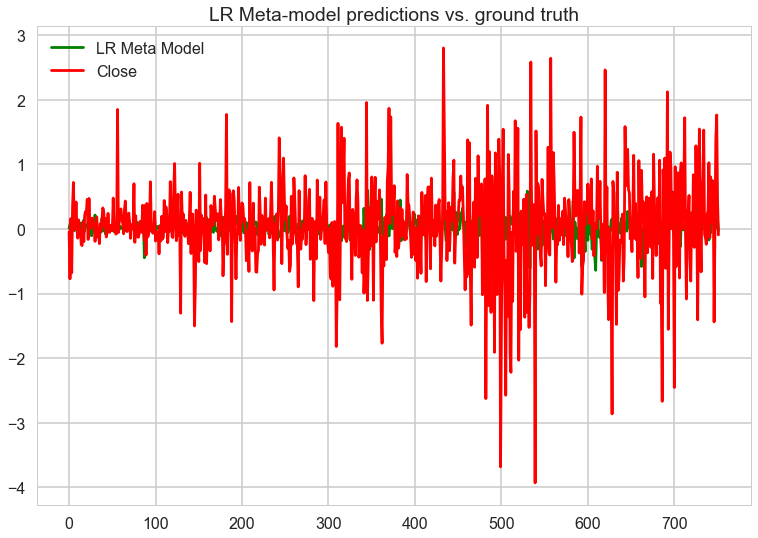

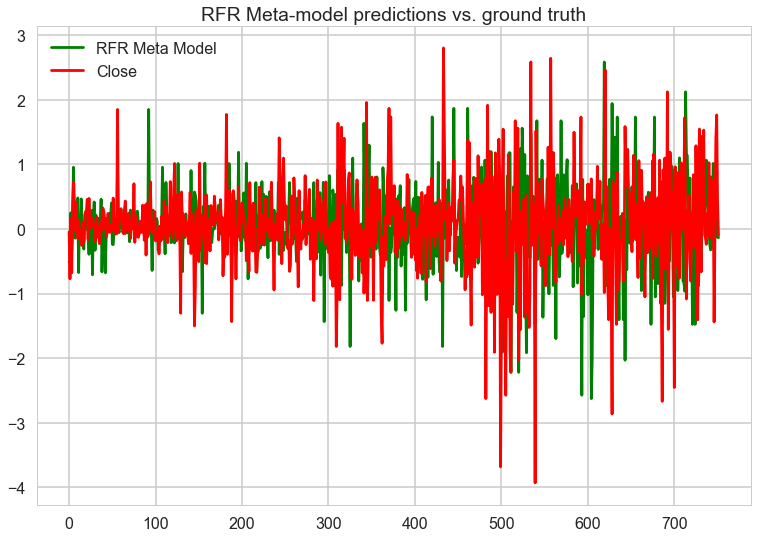

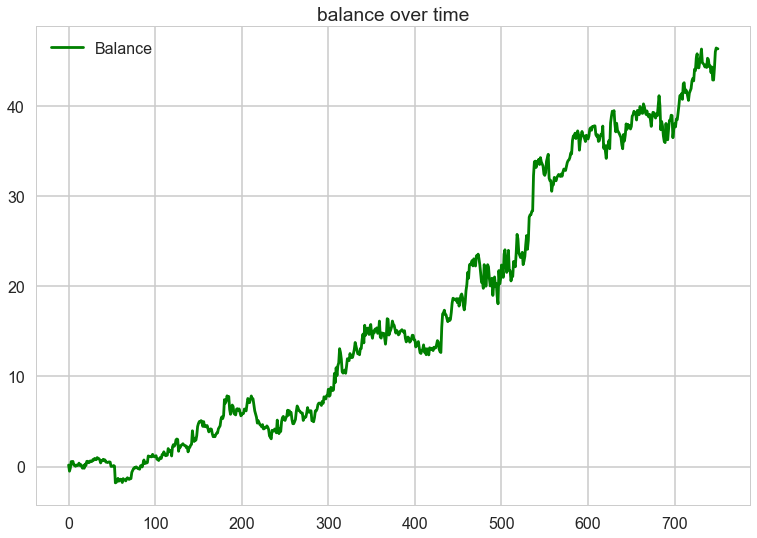

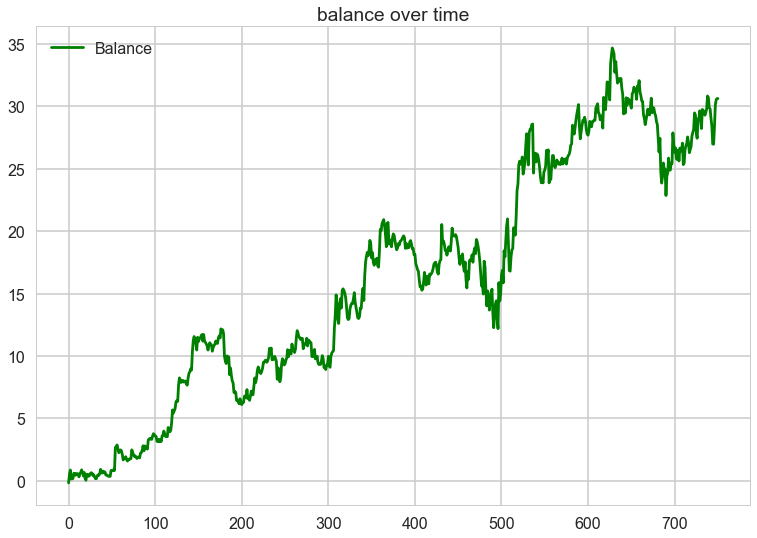

In [36]:
bmodels = list()
bmodels.append(('lr', LinearRegression()))
bmodels.append(('knn', KNeighborsRegressor()))
bmodels.append(('cart', DecisionTreeRegressor()))
bmodels.append(('svm', SVR()))
bmodels.append(("rf", RandomForestRegressor()))

first_df = training_data.loc["AAPL"].dropna()
y_past = first_df[0:first_df.shape[0]-1]
y_current = first_df[1:first_df.shape[0]]
y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

num_days_year = 253
look_back_sliding = num_days_year

ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
assert len(x_features) == len(y_features)
predictions_lr = []
predictions_rfr = []
thresholds = []
base_training_X = x_features[:start_t].reset_index(drop=True)
base_training_y = y_features[:start_t].reset_index(drop=True)
base_val_X = x_features[start_t:start_t*2].reset_index(drop=True)
base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)
# print(base_training_X, base_training_y,base_val_X, base_val_y)

print("Training base models")
meta_X_init = fit_base_ensemble(bmodels, base_training_X, base_val_X, base_training_y, base_val_y)
print("Training meta models")
meta_lr = fit_meta_ensemble(meta_X_init, base_val_y, LinearRegression(fit_intercept=False))
meta_rfr = fit_meta_ensemble(meta_X_init, base_val_y, RandomForestRegressor(bootstrap=False))
print("Predicting with no thresholding")
for t_i in tqdm(range(len(y_features) - start_t*2)):
    current_t = t_i + start_t*2
    threshold = 0
    thresholds.append(threshold)
    bmodels = list()
    bmodels.append(('lr', LinearRegression()))
    bmodels.append(('knn', KNeighborsRegressor()))
    bmodels.append(('cart', DecisionTreeRegressor()))
    bmodels.append(('svm', SVR()))
    bmodels.append(("rf", RandomForestRegressor()))
    meta_X, meta_lr, meta_rfr = 0, 0, 0
    
    base_training_X = x_features[current_t-start_t*2:current_t-start_t].reset_index(drop=True)
    base_training_y = y_features[current_t-start_t*2:current_t-start_t].reset_index(drop=True)
    base_val_X = x_features[current_t-start_t:current_t].reset_index(drop=True)
    base_val_y = y_features[current_t-start_t:current_t].reset_index(drop=True)
    
    meta_X = fit_base_ensemble(bmodels, base_training_X, base_val_X, base_training_y, base_val_y)
    meta_lr = fit_meta_ensemble(meta_X, base_val_y, LinearRegression(fit_intercept=False))
    meta_rfr = fit_meta_ensemble(meta_X, base_val_y, RandomForestRegressor(bootstrap=False))
    predictions_lr.append(predict_ensemble(bmodels, meta_lr, np.asarray([x_features.iloc[current_t]])))
    predictions_rfr.append(predict_ensemble(bmodels, meta_rfr, np.asarray([x_features.iloc[current_t]])))
balances_lr = simulate_trades(predictions_lr, ground_truth[start_t*2:], thresholds)
balances_rfr = simulate_trades(predictions_rfr, ground_truth[start_t*2:], thresholds)
plot_time_series(ts_1=predictions_lr, ts_label_1='LR Meta Model', ts_2=x_features[start_t*2:], ts_label_2='Close', title='LR Meta-model predictions vs. ground truth')
plot_time_series(ts_1=predictions_rfr, ts_label_1='RFR Meta Model', ts_2=x_features[start_t*2:], ts_label_2='Close', title='RFR Meta-model predictions vs. ground truth')
plot_balance(data=balances_lr)
plot_balance(data=balances_rfr)

# 8 stocks, performance averaged over 100 simulations for each of above

In [ ]:
specified_tickers = ["NVDA", "PYPL", "HON", "XOM", "GS", "JPM"]
num_simulations = 10

In [37]:
vanilla_results = {}
for ticker in tqdm(specified_tickers):
    print(ticker)
    vanilla_results[ticker] = {}
    vanilla_results[ticker]["lr"] = []
    vanilla_results[ticker]["rfr"] = []
    for i in tqdm(range(num_simulations)):
        bmodels = list()
        bmodels.append(('lr', LinearRegression()))
        bmodels.append(('knn', KNeighborsRegressor()))
        bmodels.append(('cart', DecisionTreeRegressor()))
        bmodels.append(('svm', SVR()))
        bmodels.append(("rf", RandomForestRegressor()))

        first_df = training_data.loc[ticker].dropna()
        y_past = first_df[0:first_df.shape[0]-1]
        y_current = first_df[1:first_df.shape[0]]
        y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
        x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
        y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

        num_days_year = 253

        ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
        assert len(x_features) == len(y_features)
        predictions_lr = []
        predictions_rfr = []
        thresholds = []
        base_training_X = x_features[:start_t].reset_index(drop=True)
        base_training_y = y_features[:start_t].reset_index(drop=True)
        base_val_X = x_features[start_t:start_t*2].reset_index(drop=True)
        base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)

#         print("Training base models")
        meta_X = fit_base_ensemble(bmodels, base_training_X, base_val_X, base_training_y, base_val_y)
#         print("Training meta models")
        meta_lr = fit_meta_ensemble(meta_X, base_val_y, LinearRegression(fit_intercept=False))
        meta_rfr = fit_meta_ensemble(meta_X, base_val_y, RandomForestRegressor(bootstrap=False))
#         print("Predicting with no thresholding")
        for t_i in (range(len(y_features) - start_t*2)):
            current_t = t_i + start_t*2
            threshold = 0
            thresholds.append(threshold)
            predictions_lr.append(predict_ensemble(bmodels, meta_lr, np.asarray([x_features.iloc[current_t]])))
            predictions_rfr.append(predict_ensemble(bmodels, meta_rfr, np.asarray([x_features.iloc[current_t]])))
        balances_lr = simulate_trades(predictions_lr, ground_truth[start_t*2:], thresholds)
        balances_rfr = simulate_trades(predictions_rfr, ground_truth[start_t*2:], thresholds)
        vanilla_results[ticker]["lr"].append(balances_lr[len(balances_lr) - 1])
        vanilla_results[ticker]["rfr"].append(balances_rfr[len(balances_rfr) - 1])
#         plot_time_series(ts_1=predictions_lr, ts_label_1='LR Meta Model', ts_2=x_features[start_t*2:], ts_label_2='Close', title='LR Meta-model predictions vs. ground truth')
#         plot_time_series(ts_1=predictions_rfr, ts_label_1='RFR Meta Model', ts_2=x_features[start_t*2:], ts_label_2='Close', title='RFR Meta-model predictions vs. ground truth')
#         plot_balance(data=balances_lr)
#         plot_balance(data=balances_rfr)








  0%|          | 0/6 [00:00<?, ?it/s]







  0%|          | 0/10 [00:00<?, ?it/s]

NVDA










 10%|█         | 1/10 [00:14<02:10, 14.48s/it]







 20%|██        | 2/10 [00:28<01:55, 14.48s/it]







 30%|███       | 3/10 [00:43<01:41, 14.49s/it]







 40%|████      | 4/10 [00:57<01:26, 14.48s/it]







 50%|█████     | 5/10 [01:12<01:12, 14.49s/it]







 60%|██████    | 6/10 [01:28<01:00, 15.09s/it]







 70%|███████   | 7/10 [01:46<00:47, 15.74s/it]







 80%|████████  | 8/10 [02:01<00:31, 15.66s/it]







 90%|█████████ | 9/10 [02:16<00:15, 15.30s/it]







100%|██████████| 10/10 [02:30<00:00, 15.05s/it]







 17%|█▋        | 1/6 [02:30<12:32, 150.54s/it]







  0%|          | 0/10 [00:00<?, ?it/s]

PYPL










 10%|█         | 1/10 [00:14<02:10, 14.46s/it]







 20%|██        | 2/10 [00:29<01:58, 14.76s/it]







 30%|███       | 3/10 [00:44<01:42, 14.67s/it]







 40%|████      | 4/10 [00:59<01:29, 14.94s/it]







 50%|█████     | 5/10 [01:14<01:14, 14.86s/it]







 60%|██████    | 6/10 [01:29<00:59, 14.86s/it]







 70%|███████   | 7/10 [01:44<00:44, 14.78s/it]







 80%|████████  | 8/10 [01:58<00:29, 14.75s/it]







 90%|█████████ | 9/10 [02:13<00:14, 14.71s/it]







100%|██████████| 10/10 [02:27<00:00, 14.79s/it]







 33%|███▎      | 2/6 [04:58<09:58, 149.74s/it]







  0%|          | 0/10 [00:00<?, ?it/s]

HON










 10%|█         | 1/10 [00:14<02:10, 14.51s/it]







 20%|██        | 2/10 [00:28<01:56, 14.50s/it]







 30%|███       | 3/10 [00:43<01:41, 14.54s/it]







 40%|████      | 4/10 [00:59<01:28, 14.80s/it]







 50%|█████     | 5/10 [01:14<01:15, 15.08s/it]







 60%|██████    | 6/10 [01:29<00:59, 14.94s/it]







 70%|███████   | 7/10 [01:43<00:44, 14.81s/it]







 80%|████████  | 8/10 [01:58<00:29, 14.79s/it]







 90%|█████████ | 9/10 [02:13<00:14, 14.71s/it]







100%|██████████| 10/10 [02:27<00:00, 14.77s/it]







 50%|█████     | 3/6 [07:26<07:27, 149.14s/it]







  0%|          | 0/10 [00:00<?, ?it/s]

XOM










 10%|█         | 1/10 [00:14<02:10, 14.50s/it]







 20%|██        | 2/10 [00:29<01:55, 14.50s/it]







 30%|███       | 3/10 [00:43<01:41, 14.54s/it]







 40%|████      | 4/10 [00:58<01:27, 14.65s/it]







 50%|█████     | 5/10 [01:13<01:12, 14.59s/it]







 60%|██████    | 6/10 [01:28<00:59, 14.91s/it]







 70%|███████   | 7/10 [01:43<00:44, 14.89s/it]







 80%|████████  | 8/10 [01:58<00:29, 14.85s/it]







 90%|█████████ | 9/10 [02:12<00:14, 14.77s/it]







100%|██████████| 10/10 [02:27<00:00, 14.76s/it]







 67%|██████▋   | 4/6 [09:53<04:57, 148.67s/it]







  0%|          | 0/10 [00:00<?, ?it/s]

GS










 10%|█         | 1/10 [00:14<02:11, 14.58s/it]







 20%|██        | 2/10 [00:29<01:56, 14.54s/it]







 30%|███       | 3/10 [00:43<01:41, 14.51s/it]







 40%|████      | 4/10 [00:57<01:26, 14.49s/it]







 50%|█████     | 5/10 [01:12<01:12, 14.49s/it]







 60%|██████    | 6/10 [01:27<00:58, 14.53s/it]







 70%|███████   | 7/10 [01:41<00:43, 14.54s/it]







 80%|████████  | 8/10 [01:56<00:29, 14.65s/it]







 90%|█████████ | 9/10 [02:13<00:15, 15.51s/it]







100%|██████████| 10/10 [02:29<00:00, 14.93s/it]







 83%|████████▎ | 5/6 [12:23<02:28, 148.86s/it]







  0%|          | 0/10 [00:00<?, ?it/s]

JPM










 10%|█         | 1/10 [00:14<02:12, 14.69s/it]







 20%|██        | 2/10 [00:29<01:58, 14.77s/it]







 30%|███       | 3/10 [00:44<01:43, 14.72s/it]







 40%|████      | 4/10 [00:59<01:28, 14.78s/it]







 50%|█████     | 5/10 [01:13<01:13, 14.71s/it]







 60%|██████    | 6/10 [01:28<00:58, 14.70s/it]







 70%|███████   | 7/10 [01:44<00:45, 15.20s/it]







 80%|████████  | 8/10 [02:01<00:31, 15.52s/it]







 90%|█████████ | 9/10 [02:16<00:15, 15.64s/it]







100%|██████████| 10/10 [02:32<00:00, 15.22s/it]







100%|██████████| 6/6 [14:55<00:00, 149.20s/it]


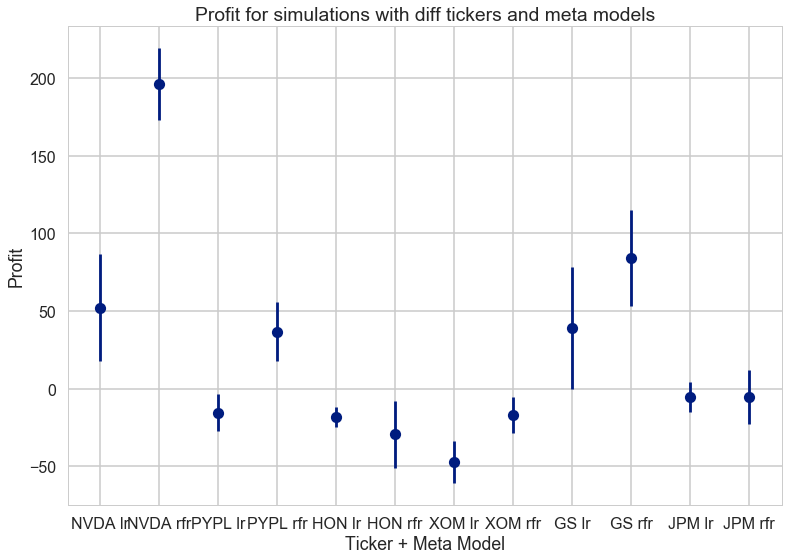

In [38]:
vanilla_results_mean = []
vanilla_results_std = []
labels = []
for ticker in specified_tickers:
    vanilla_results_mean.append(np.mean(np.asarray(vanilla_results[ticker]["lr"])))
    vanilla_results_mean.append(np.mean(np.asarray(vanilla_results[ticker]["rfr"])))
    vanilla_results_std.append(np.std(np.asarray(vanilla_results[ticker]["lr"])))
    vanilla_results_std.append(np.std(np.asarray(vanilla_results[ticker]["rfr"])))
    labels.append(ticker + " lr")
    labels.append(ticker + " rfr")
    
fig, ax = plt.subplots()
ax.errorbar(labels, vanilla_results_mean, yerr=vanilla_results_std, fmt='o')
ax.set_xlabel('Ticker + Meta Model')
ax.set_ylabel('Profit')
ax.set_title('Profit for simulations with diff tickers and meta models')
plt.show()

In [ ]:
slide_meta_results = {}
for ticker in tqdm(specified_tickers):
    print(ticker)
    slide_meta_results[ticker] = {}
    slide_meta_results[ticker]["lr"] = []
    slide_meta_results[ticker]["rfr"] = []
    for i in tqdm(range(num_simulations)):
        bmodels = list()
        bmodels.append(('lr', LinearRegression()))
        bmodels.append(('knn', KNeighborsRegressor()))
        bmodels.append(('cart', DecisionTreeRegressor()))
        bmodels.append(('svm', SVR()))
        bmodels.append(("rf", RandomForestRegressor()))

        first_df = training_data.loc[ticker].dropna()
        y_past = first_df[0:first_df.shape[0]-1]
        y_current = first_df[1:first_df.shape[0]]
        y_features = y_current.reset_index(drop=True) - y_past.reset_index(drop=True)
        x_features = pd.DataFrame({'x': list(y_features[0:y_features.shape[0]-1].to_numpy())})
        y_features = y_features[1:y_features.shape[0]].reset_index(drop=True)

        num_days_year = 253
        look_back_sliding = num_days_year

        ground_truth, start_t = first_df[1:first_df.shape[0]-1].to_numpy(), int(num_days_year/2)
        assert len(x_features) == len(y_features)
        predictions_lr = []
        predictions_rfr = []
        thresholds = []
        base_training_X = x_features[:start_t].reset_index(drop=True)
        base_training_y = y_features[:start_t].reset_index(drop=True)
        base_val_X = x_features[start_t:start_t*2].reset_index(drop=True)
        base_val_y = y_features[start_t:start_t*2].reset_index(drop=True)
        # print(base_training_X, base_training_y,base_val_X, base_val_y)

#         print("Training base models")
        meta_X_init = fit_base_ensemble(bmodels, base_training_X, base_val_X, base_training_y, base_val_y)
#         print("Training meta models")
        meta_lr = fit_meta_ensemble(meta_X_init, base_val_y, LinearRegression(fit_intercept=False))
        meta_rfr = fit_meta_ensemble(meta_X_init, base_val_y, RandomForestRegressor(bootstrap=False))
#         print("Predicting with no thresholding")
        for t_i in (range(len(y_features) - start_t*2)):
            current_t = t_i + start_t*2
            threshold = 0
            thresholds.append(threshold)
            meta_X, meta_lr, meta_rfr = 0, 0, 0
            meta_X = predict_base_ensemble(bmodels, x_features[current_t-start_t:current_t].reset_index(drop=True))
            meta_lr = fit_meta_ensemble(meta_X, y_features[current_t-start_t:current_t].reset_index(drop=True), LinearRegression(fit_intercept=False))
            meta_rfr = fit_meta_ensemble(meta_X, y_features[current_t-start_t:current_t].reset_index(drop=True), RandomForestRegressor(bootstrap=False))
            predictions_lr.append(predict_ensemble(bmodels, meta_lr, np.asarray([x_features.iloc[current_t]])))
            predictions_rfr.append(predict_ensemble(bmodels, meta_rfr, np.asarray([x_features.iloc[current_t]])))
        balances_lr = simulate_trades(predictions_lr, ground_truth[start_t*2:], thresholds)
        balances_rfr = simulate_trades(predictions_rfr, ground_truth[start_t*2:], thresholds)
        slide_meta_results[ticker]["lr"].append(balances_lr[len(balances_lr) - 1])
        slide_meta_results[ticker]["rfr"].append(balances_rfr[len(balances_rfr) - 1])
#         plot_time_series(ts_1=predictions_lr, ts_label_1='LR Meta Model', ts_2=x_features[start_t*2:], ts_label_2='Close', title='LR Meta-model predictions vs. ground truth')
#         plot_time_series(ts_1=predictions_rfr, ts_label_1='RFR Meta Model', ts_2=x_features[start_t*2:], ts_label_2='Close', title='RFR Meta-model predictions vs. ground truth')
#         plot_balance(data=balances_lr)
#         plot_balance(data=balances_rfr)

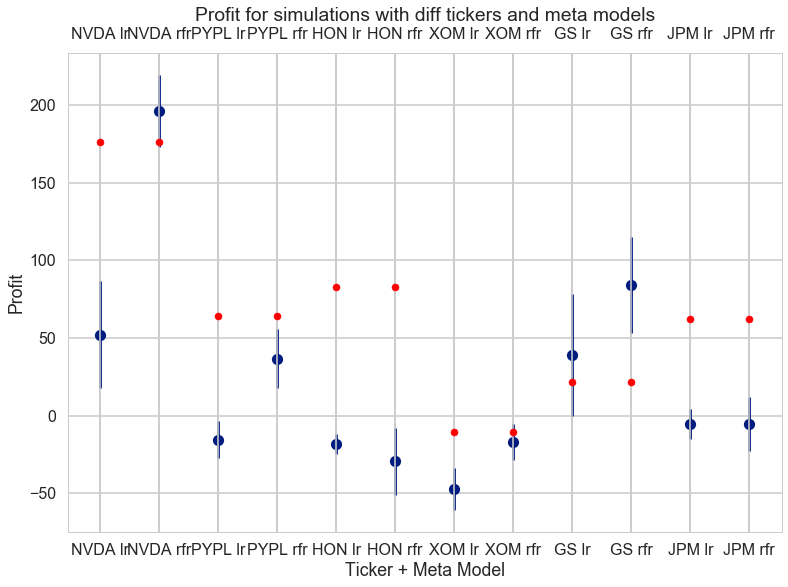

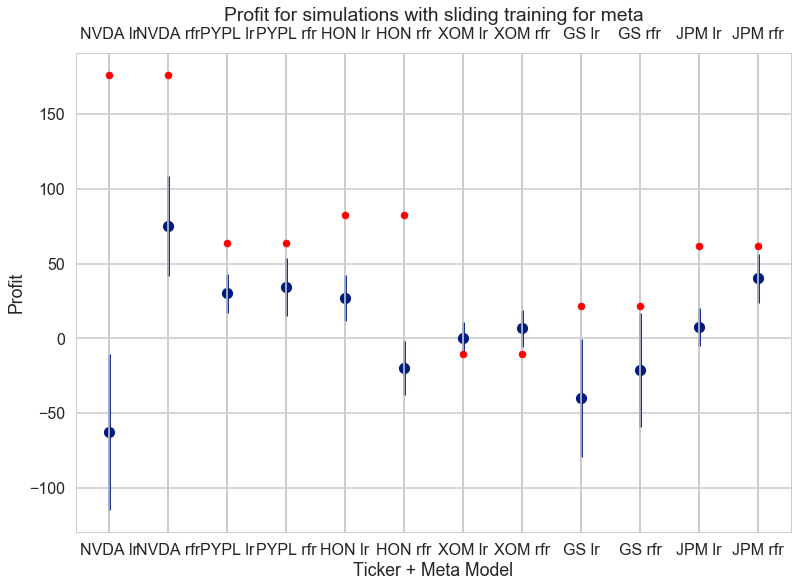

In [55]:
buy_and_hold = []
vanilla_results_mean = []
vanilla_results_std = []
labels = []
for ticker in specified_tickers:
    prices=training_data.loc[ticker].dropna()
    buy_and_hold.append(prices[prices.shape[0]-1] - prices[0])
    buy_and_hold.append(prices[prices.shape[0]-1] - prices[0])
    vanilla_results_mean.append(np.mean(np.asarray(vanilla_results[ticker]["lr"])))
    vanilla_results_mean.append(np.mean(np.asarray(vanilla_results[ticker]["rfr"])))
    vanilla_results_std.append(np.std(np.asarray(vanilla_results[ticker]["lr"])))
    vanilla_results_std.append(np.std(np.asarray(vanilla_results[ticker]["rfr"])))
    labels.append(ticker + " lr")
    labels.append(ticker + " rfr")
    
fig, ax = plt.subplots()
ax2 = ax.twiny()
ax2.scatter(labels, buy_and_hold, s= 50, c='r')
ax.errorbar(labels, vanilla_results_mean, yerr=vanilla_results_std, fmt='o')
ax.set_xlabel('Ticker + Meta Model')
ax.set_ylabel('Profit')
ax.set_title('Profit for simulations with diff tickers and meta models')
plt.show()

slide_meta_results_mean = []
slide_meta_results_std = []
labels = []
for ticker in specified_tickers:
    slide_meta_results_mean.append(np.mean(np.asarray(slide_meta_results[ticker]["lr"])))
    slide_meta_results_mean.append(np.mean(np.asarray(slide_meta_results[ticker]["rfr"])))
    slide_meta_results_std.append(np.std(np.asarray(slide_meta_results[ticker]["lr"])))
    slide_meta_results_std.append(np.std(np.asarray(slide_meta_results[ticker]["rfr"])))
    labels.append(ticker + " lr")
    labels.append(ticker + " rfr")
    
fig, ax = plt.subplots()
ax2 = ax.twiny()
ax2.scatter(labels, buy_and_hold, s= 50, c='r')
ax.errorbar(labels, slide_meta_results_mean, yerr=slide_meta_results_std, fmt='o')
ax.set_xlabel('Ticker + Meta Model')
ax.set_ylabel('Profit')
ax.set_title('Profit for simulations with sliding training for meta')
plt.show()